<div style="background-color:white">
  <div align="center">
    <img src="https://www.doc.zuv.fau.de//M/FAU-Logo/Tech/Web/Tech_Fak_Logo_854x334_rgb.jpg" width="400" height="250">
    <hr>
    <h1 style="color:black">Identify Trial Population for Clinical Studies on Diabetes<h1>
    <img src="https://www.mad.tf.fau.de/files/2019/04/logo_mad.png" width="230" height="150">
        <h2>Explainable AI Notebook</h2>
  </div>
  <hr>
</div>

### `Outline of the Notebook`

- [1. LIME](#1)
- [2. SHAP](#2)

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from keras.optimizers import Adamax
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import aequitas as ae
from sklearn.metrics import auc, f1_score, roc_auc_score, recall_score, precision_score, brier_score_loss, accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor


import sys  
sys.path.insert(0, '../Scripts')

from model_preprocessing_utils import *
from tensorflow_modeling import *
from utils import check_null_values

os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn.datasets import load_boston
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular
import xgboost as xgb

Using TensorFlow backend.


<a name='1'></a>
# LIME

In [8]:
df = pd.read_csv("../../data/final_preprocessed_df.csv").dropna()
print(f"Shape: {df.shape}")
df.head()

Shape: (120057, 25)


encounter_id  patient_nbr             race  gender      age  \
1        149190     55629189        Caucasian  Female  [10-20)   
2         64410     86047875  AfricanAmerican  Female  [20-30)   
3        500364     82442376        Caucasian    Male  [30-40)   
4         16680     42519267        Caucasian    Male  [40-50)   
5         16680     42519267        Caucasian    Male  [40-50)   

   admission_type_id  discharge_disposition_id  admission_source_id  \
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   
5                  1                         1                    7   

   time_in_hospital payer_code  ... number_emergency  number_inpatient  \
1                 3          ?  ...                0                 0   
2                 2          ?  ...                0                 1   
3                 2          ?  ...                0                 0   
4                 1          ?  ...                0                 0   
5                 1          ?  ...                0                 0   

   primary_diagnosis_code  number_diagnoses  max_glu_serum  A1Cresult  change  \
1                     276                 9           None       None      Ch   
2                     648                 6           None       None      No   
3                       8                 7           None       None      Ch   
4                     197                 5           None       None      Ch   
5                     197                 5           None       None      Ch   

  readmitted  secondary_diagnosis_codes     drug_name  
1        >30                 250.01|255  Troglitazone  
2         NO                    250|V27  Troglitazone  
3         NO                 250.43|403  Troglitazone  
4         NO                    157|250     Glipizide  
5         NO                    157|250       Insulin  

[5 rows x 25 columns]

In [9]:
grouping_field_list = ['encounter_id']
non_grouped_field_list = [c for c in df.columns if c not in grouping_field_list]

encounter_df = df.groupby(grouping_field_list)[non_grouped_field_list].agg(lambda x: 
                                                        list([y for y in x if y is not np.nan ] ) ).reset_index()

false_indexes = encounter_df[encounter_df['time_in_hospital'].apply(lambda x: x[1] != x[0] if len(x) == 2 else x[0]) == True].index

reduced_encounter_df = encounter_df.loc[set(encounter_df.index) - set(false_indexes)].copy()

In [10]:
reduced_encounter_df.shape

(71019, 25)

In [11]:
y_label_reduces = reduced_encounter_df['time_in_hospital'].apply(lambda x: x[0] if len(x) == 2 else x[0])

In [12]:
train, test = sklearn.model_selection.train_test_split(reduced_encounter_df, 
                                                       stratify=y_label_reduces, 
                                                       train_size=0.80)

In [13]:
print(f"Line Level Train size: {train.shape}")
print(f"Line Level Test size: {test.shape}")

Line Level Train size: (56815, 25)
Line Level Test size: (14204, 25)


In [14]:
encounter_train = train.set_index(['encounter_id']).apply(pd.Series.explode).reset_index()
encounter_test = test.set_index(['encounter_id']).apply(pd.Series.explode).reset_index()

In [15]:
train_label = encounter_train['time_in_hospital']
test_label = encounter_test['time_in_hospital']

encounter_train = encounter_train.drop('time_in_hospital', axis=1).copy()
encounter_test = encounter_test.drop('time_in_hospital', axis=1).copy()

print(f"Encounter Level Train size: {encounter_train.shape}")
print(f"Encounter Level Test size: {encounter_test.shape}")

Encounter Level Train size: (88698, 24)
Encounter Level Test size: (22218, 24)


In [16]:
"""
# Train
col_cat_other_codes = encounter_train['secondary_diagnosis_codes'].str.split("|")
other_diagnosis_codes = ['sec_diagnosis_code_1', 'sec_diagnosis_code_2']

for codes, col in zip(col_cat_other_codes, other_diagnosis_codes):
    encounter_train[col] = codes[0]
    encounter_train[col] = codes[1]
    
encounter_train = encounter_train.drop(['secondary_diagnosis_codes'], axis=1).copy()

# Test
col_cat_other_codes = encounter_test['secondary_diagnosis_codes'].str.split("|")
other_diagnosis_codes = ['sec_diagnosis_code_1', 'sec_diagnosis_code_2']

for codes, col in zip(col_cat_other_codes, other_diagnosis_codes):
    encounter_test[col] = codes[0]
    encounter_test[col] = codes[1]
    
encounter_test = encounter_test.drop(['secondary_diagnosis_codes'], axis=1).copy()
"""

'\n# Train\ncol_cat_other_codes = encounter_train[\'secondary_diagnosis_codes\'].str.split("|")\nother_diagnosis_codes = [\'sec_diagnosis_code_1\', \'sec_diagnosis_code_2\']\n\nfor codes, col in zip(col_cat_other_codes, other_diagnosis_codes):\n    encounter_train[col] = codes[0]\n    encounter_train[col] = codes[1]\n    \nencounter_train = encounter_train.drop([\'secondary_diagnosis_codes\'], axis=1).copy()\n\n# Test\ncol_cat_other_codes = encounter_test[\'secondary_diagnosis_codes\'].str.split("|")\nother_diagnosis_codes = [\'sec_diagnosis_code_1\', \'sec_diagnosis_code_2\']\n\nfor codes, col in zip(col_cat_other_codes, other_diagnosis_codes):\n    encounter_test[col] = codes[0]\n    encounter_test[col] = codes[1]\n    \nencounter_test = encounter_test.drop([\'secondary_diagnosis_codes\'], axis=1).copy()\n'

### Features

In [17]:
high_kardinality = ['encounter_id', 'patient_nbr','medical_specialty', 
                    'primary_diagnosis_code', 'A1Cresult', 'payer_code', 'secondary_diagnosis_codes']

numerical_feature_list = ['number_emergency', 'number_inpatient', 'number_diagnoses', 
                          'num_procedures', 'num_lab_procedures', 'number_outpatient',
                         'num_medications']

In [18]:
encounter_train_low_kard = encounter_train.drop(high_kardinality, axis=1).copy()
encounter_test_low_kard = encounter_test.drop(high_kardinality, axis=1).copy()

In [19]:
## Dummy vars
train_objs_num = len(encounter_train_low_kard)
dataset = pd.concat(objs=[encounter_train_low_kard, encounter_test_low_kard], axis=0)
dataset_preprocessed = pd.get_dummies(dataset.drop(numerical_feature_list, axis=1))

train_preprocessed = dataset_preprocessed[:train_objs_num]
test_preprocessed = dataset_preprocessed[train_objs_num:]

print(f"Final Train Shape: {train_preprocessed.shape}")
print(f"Final Test Shape: {test_preprocessed.shape}")

Final Train Shape: (88698, 99)
Final Test Shape: (22218, 99)


In [20]:
train_combined = pd.concat([train_preprocessed, encounter_train_low_kard[numerical_feature_list]], axis=1)
test_combined = pd.concat([test_preprocessed, encounter_test_low_kard[numerical_feature_list]], axis=1)

print(f"Final Train Shape: {train_combined.shape}")
print(f"Final Test Shape: {test_combined.shape}")

Final Train Shape: (88698, 106)
Final Test Shape: (22218, 106)


In [23]:
categorical_feature_list = set(train_preprocessed.columns) - set(numerical_feature_list)

assert len(numerical_feature_list) + len(categorical_feature_list) == train_combined.shape[1]

print(f"Categorical Features: {len(categorical_feature_list)}")
print(f"Numerical Features: {len(numerical_feature_list)}")

Categorical Features: 99
Numerical Features: 7


#### Train the Model

In [41]:
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=1000)

In [42]:
lime_model = rf.fit(train_preprocessed, train_label)

In [43]:
print('Random Forest MSError', np.mean((rf.predict(test_preprocessed) - test_label) ** 2))
print('MSError when predicting the mean', np.mean((train_label.mean() - test_label) ** 2))

Random Forest MSError 8.948345465120692
MSError when predicting the mean 8.680602279229454


In [44]:
y_pred = lime_model.predict(test_preprocessed)

In [45]:
#F1, precision and recall
print("Accuracy score : ", accuracy_score(test_label.astype(int), y_pred.astype(int)))
print("F1 score : ", f1_score(test_label.astype(int), y_pred.astype(int), average='weighted'))
print("Precision score: ", precision_score(test_label.astype(int), y_pred.astype(int), average='micro'))
print("Recall score : ", recall_score(test_label.astype(int), y_pred.astype(int), average='micro'))

Accuracy score :  0.15721487082545685
F1 score :  0.13299962712454785
Precision score:  0.15721487082545685
Recall score :  0.15721487082545685


### Model LIME

In [46]:
categorical_features = np.argwhere(
    np.array([len(set(encounter_train.values[:,x])) for x in range(encounter_train.shape[1])]) <= 10).flatten()

In [47]:
explainer = lime.lime_tabular.LimeTabularExplainer(train_preprocessed.values, 
                                                   feature_names=train_preprocessed.columns, 
                                                   class_names=['time_in_hospital'], 
                                                   categorical_features=categorical_features, 
                                                   verbose=True, 
                                                   mode='regression')

In [48]:
ids_mapping_path = "../../data/schemas/IDs_mapping.csv"
ids_mapping = pd.read_csv(ids_mapping_path)
#ids_mapping.iloc[8:40].iloc[16]['description']

### 1) More numerical features

`Discharge Disposition ID`


- discharge_disposition_id_1: Discharged to home
- discharge_disposition_id_15: 'Discharged/transferred within this institution to Medicare approved swing bed'
- discharge_disposition_id_27: NaN
- **discharge_disposition_id_6: Discharged/transferred to home with home health service**

`Admission Source ID`

- admission_source_id_5: Transfer from a Skilled Nursing Facility (SNF)
- admission_source_id_4: Transfer from a hospital
- admission_source_id_10: Transfer from critial access hospital
- **admission_source_id_17: NaN**

`Admission Type ID`

- **admission_type_id_1: Emergency**

In [49]:
test_preprocessed

race_?  race_AfricanAmerican  race_Asian  race_Caucasian  \
0           0                     0           0               1   
1           0                     0           0               1   
2           0                     0           0               1   
3           0                     0           0               1   
4           0                     1           0               0   
...       ...                   ...         ...             ...   
22213       0                     1           0               0   
22214       0                     1           0               0   
22215       0                     1           0               0   
22216       0                     1           0               0   
22217       0                     1           0               0   

       race_Hispanic  race_Other  gender_Female  gender_Male  \
0                  0           0              1            0   
1                  0           0              1            0   
2                  0           0              0            1   
3                  0           0              0            1   
4                  0           0              1            0   
...              ...         ...            ...          ...   
22213              0           0              1            0   
22214              0           0              1            0   
22215              0           0              1            0   
22216              0           0              1            0   
22217              0           0              1            0   

       gender_Unknown/Invalid  age_[0-10)  ...  \
0                           0           0  ...   
1                           0           0  ...   
2                           0           0  ...   
3                           0           0  ...   
4                           0           0  ...   
...                       ...         ...  ...   
22213                       0           0  ...   
22214                       0           0  ...   
22215                       0           0  ...   
22216                       0           0  ...   
22217                       0           0  ...   

       drug_name_Metformin Pioglitazone  drug_name_Metformin Rosiglitazone  \
0                                     0                                  0   
1                                     0                                  0   
2                                     0                                  0   
3                                     0                                  0   
4                                     0                                  0   
...                                 ...                                ...   
22213                                 0                                  0   
22214                                 0                                  0   
22215                                 0                                  0   
22216                                 0                                  0   
22217                                 0                                  0   

       drug_name_Miglitol  drug_name_Nateglinide  drug_name_Pioglitazone  \
0                       0                      0                       0   
1                       0                      0                       0   
2                       0                      0                       0   
3                       0                      0                       0   
4                       0                      0                       0   
...                   ...                    ...                     ...   
22213                   0                      0                       1   
22214                   0                      0                       0   
22215                   0                      0                       0   
22216                   0                      0                       0   
22217                   0                      0           

In [405]:
test_preprocessed.iloc[10][test_preprocessed.iloc[10] == 1]

race_Caucasian                1
gender_Female                 1
age_[70-80)                   1
admission_type_id_1           1
discharge_disposition_id_6    1
admission_source_id_17        1
max_glu_serum_>300            1
change_Ch                     1
readmitted_NO                 1
drug_name_Rosiglitazone       1
Name: 10, dtype: uint8

In [166]:
i = 10


exp = explainer.explain_instance(test_preprocessed.values[i], lime_model.predict, num_features=9)

print(f"\nReal Label: {test_label[i]}")

exp.show_in_notebook(show_table=True)

Intercept 6.75197087512686
Prediction_local [5.67045426]
Right: 6.419720774259283

Real Label: 7


In [165]:
i = 131

exp = explainer.explain_instance(test_preprocessed.values[i], lime_model.predict, num_features=9)

print(f"\nReal Label: {test_label[i]}")

exp.show_in_notebook(show_table=True)

Intercept 8.311844249596659
Prediction_local [5.66260677]
Right: 6.141111631832223

Real Label: 10


`Discharge Disposition ID`

- **discharge_disposition_id_7: Left AMA**
- discharge_disposition_id_17: Discharged/transferred/referred to this institution for outpatient services
- discharge_disposition_id_9: Admitted as an inpatient to this hospital

`Admission Source ID`

- admission_source_id_5: Transfer from a Skilled Nursing Facility (SNF)
- admission_source_id_4: Transfer from a hospital
- admission_source_id_10: Transfer from critial access hospital

`Admission Type ID`

- admission_type_id_6: NULL

In [59]:
test_preprocessed.iloc[60][test_preprocessed.iloc[60] == 1]

race_Caucasian                1
gender_Male                   1
age_[90-100)                  1
admission_type_id_1           1
discharge_disposition_id_6    1
admission_source_id_7         1
max_glu_serum_None            1
change_Ch                     1
readmitted_<30                1
drug_name_Insulin             1
Name: 60, dtype: uint8

In [159]:
i = 60

exp = explainer.explain_instance(test_preprocessed.values[i], lime_model.predict, num_features=9)

print(f"\nReal Label: {test_label[i]}")

exp.show_in_notebook(show_table=True)

Intercept 9.286809639096871
Prediction_local [4.1188695]
Right: 3.8749013625195263

Real Label: 3


### 2) Fewer numerical features

In [36]:
i = 25

exp = explainer.explain_instance(test_preprocessed.values[i], lime_model.predict, num_features=9)

Intercept 13.71853832571879
Prediction_local [4.89763451]
Right: 2.949


In [37]:
exp.show_in_notebook(show_table=True)

In [24]:
exp.as_list()

[('num_medications_1 <= 0.00', -2.37808259158988),
 ('num_medications_30 <= 0.00', -2.119941559586811),
 ('discharge_disposition_id_24 <= 0.00', -1.7494129834641705),
 ('num_medications_32 <= 0.00', -1.5481707272296923),
 ('number_emergency_12 <= 0.00', -1.5216040532568045),
 ('num_medications_34 <= 0.00', -1.5044117590623491),
 ('num_medications_60 <= 0.00', -1.4730064596851515),
 ('num_medications_29 <= 0.00', -1.2428353920544244),
 ('num_medications_66 <= 0.00', 1.1670382287124503),
 ('num_medications_33 <= 0.00', -1.0734586128492696),
 ('num_medications_36 <= 0.00', -0.9798217920972047),
 ('admission_type_id_7 <= 0.00', 0.6291924238305108),
 ('num_medications_58 <= 0.00', 0.2666507888916137),
 ('num_lab_procedures_97 <= 0.00', -0.23314899612712925),
 ('number_diagnoses_10 <= 0.00', 0.16403074413967045)]

<a name='2'></a>

# Shapely

In [25]:
import shap
shap.initjs()

In [26]:
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(train_combined, train_label)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

### Summary Plot TRAIN

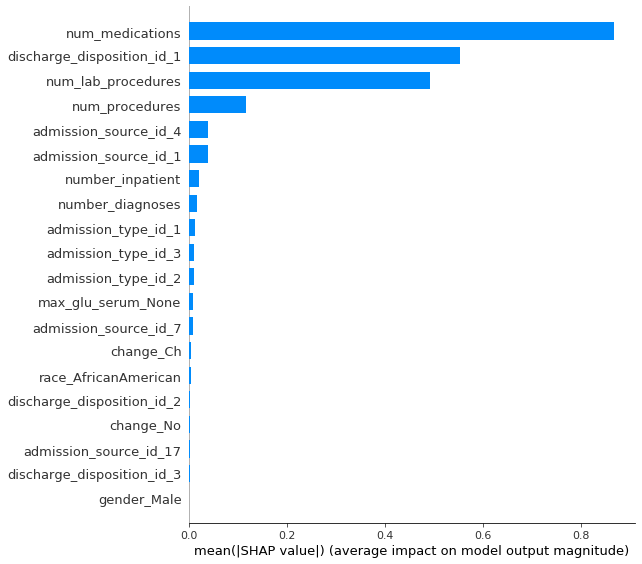

In [37]:
shap_values = shap.TreeExplainer(model).shap_values(train_combined)
f = plt.figure()
shap.summary_plot(shap_values, train_combined, plot_type="bar")
f.savefig("./summary_plot_train_1.png", bbox_inches='tight', dpi=600)

### Summary Plot TEST

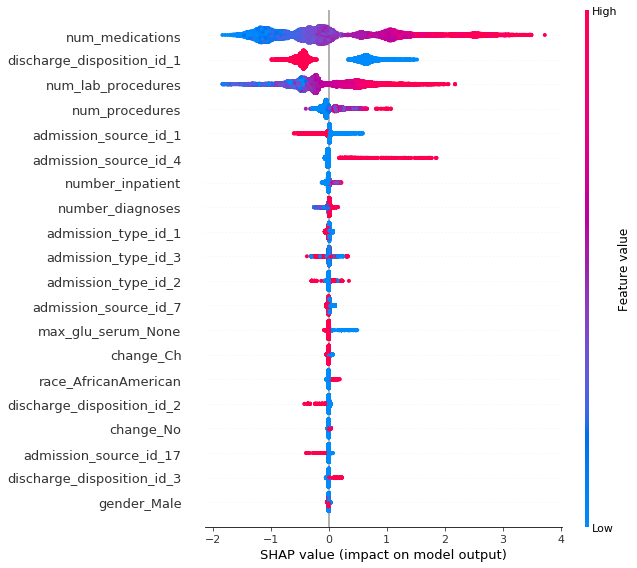

In [28]:
shap_values_test = shap.TreeExplainer(model).shap_values(test_combined)

f = plt.figure()
shap.summary_plot(shap_values_test, test_combined)
f.savefig("./summary_plot_test_2.png", bbox_inches='tight', dpi=600)

### Dependence Plot

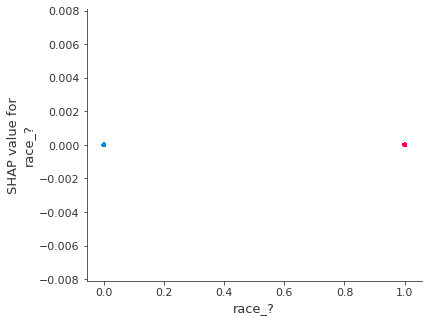

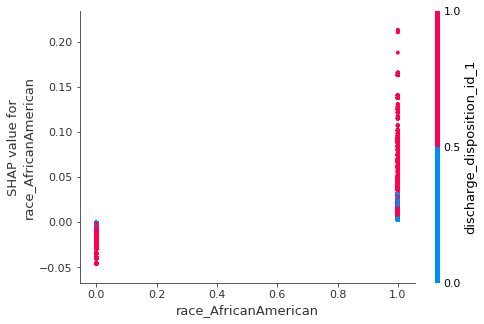

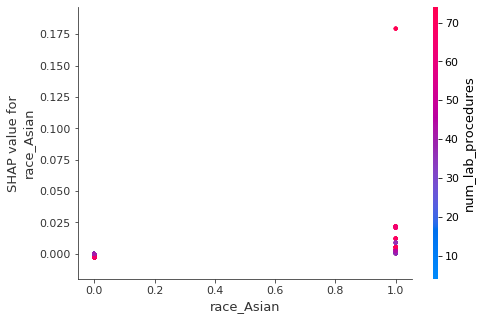

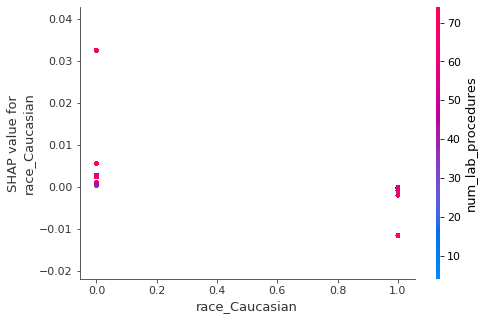

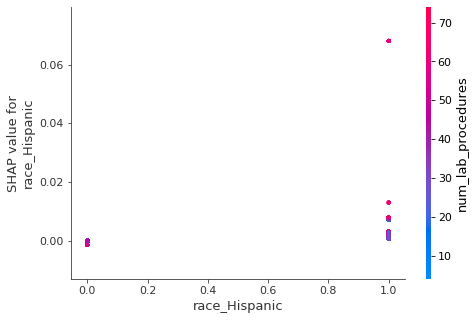

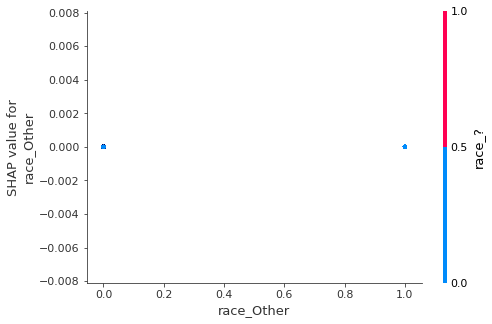

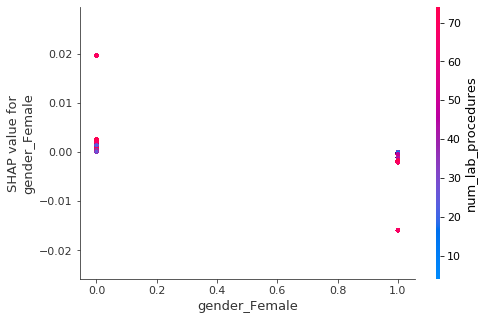

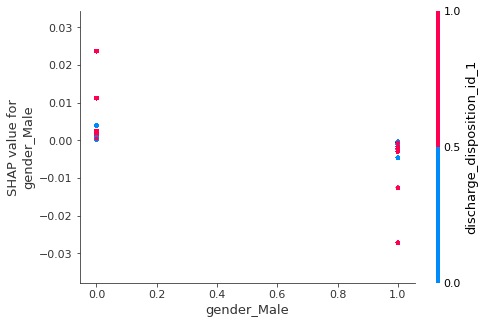

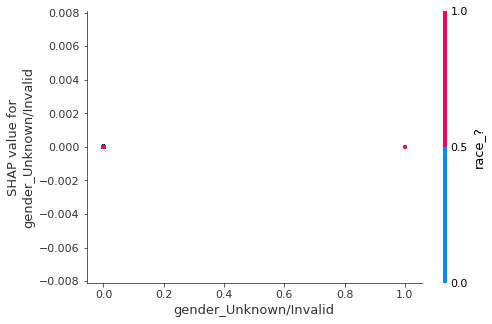

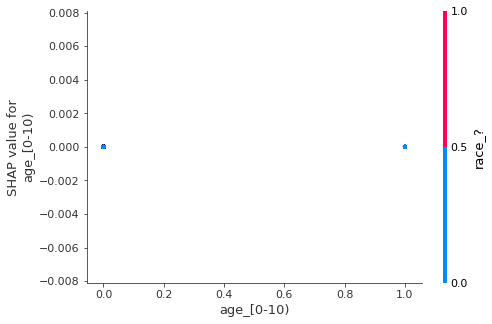

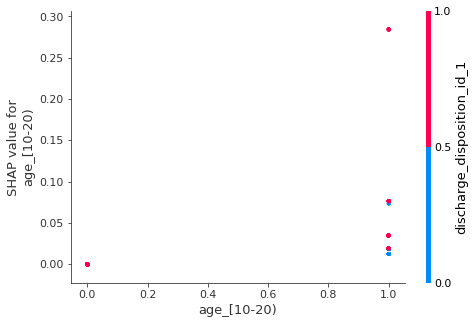

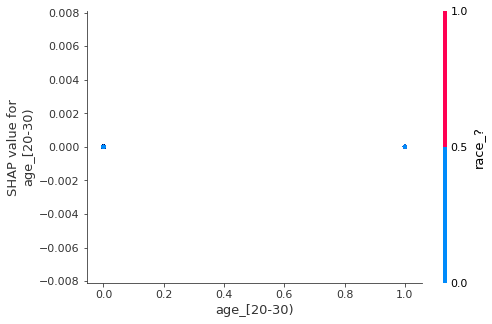

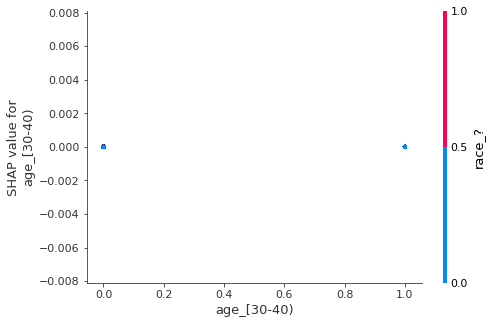

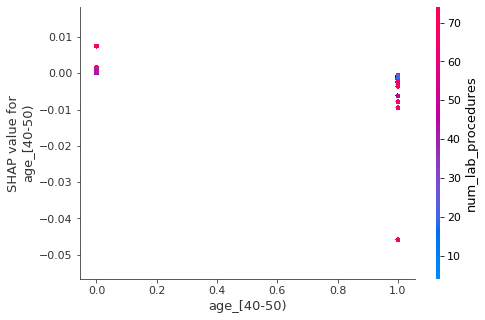

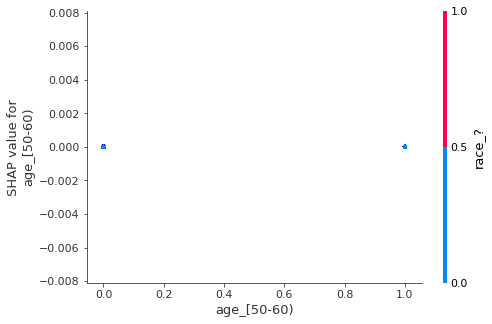

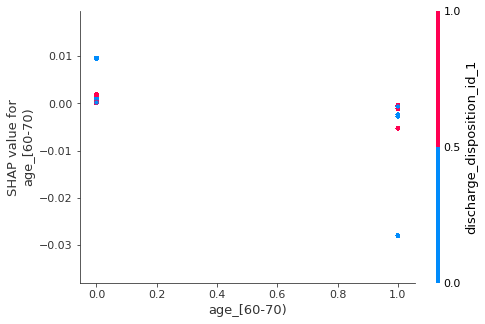

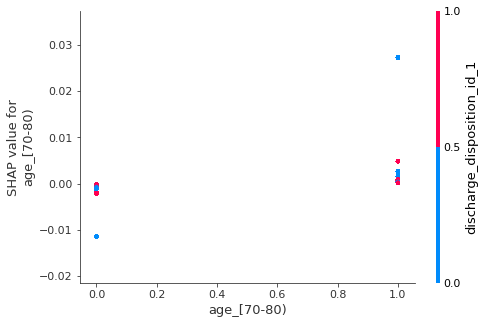

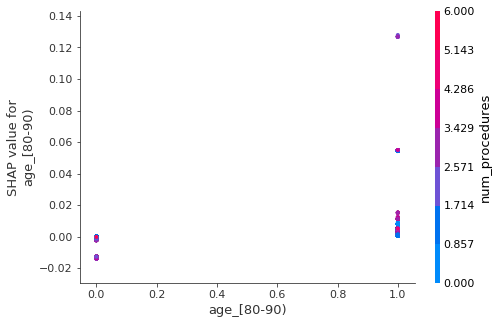

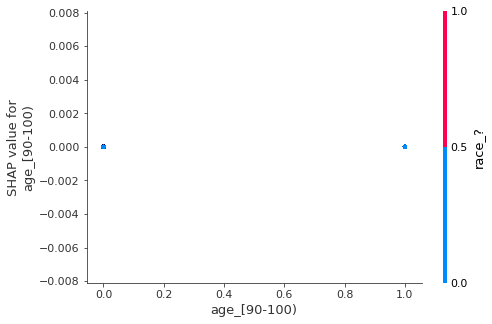

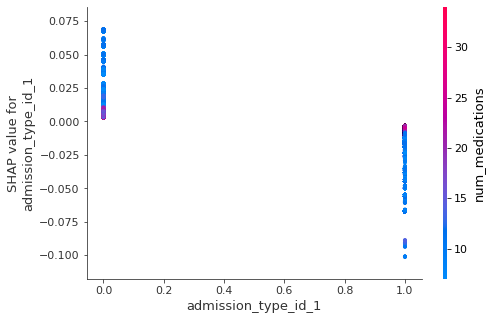

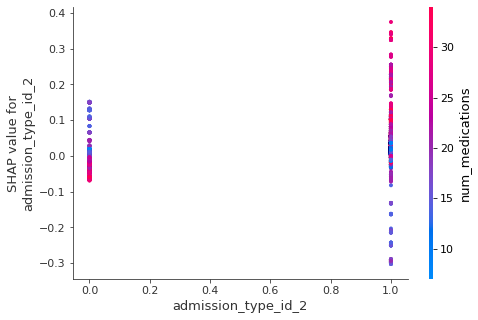

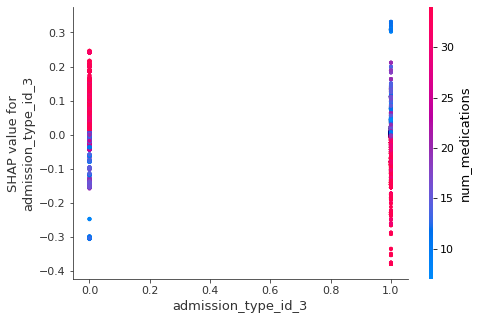

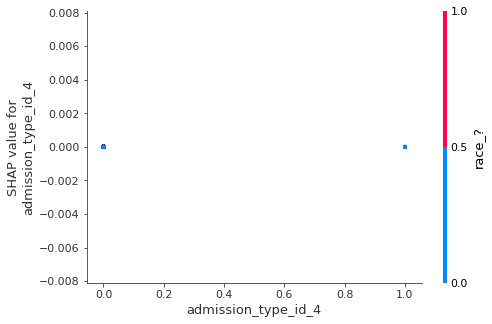

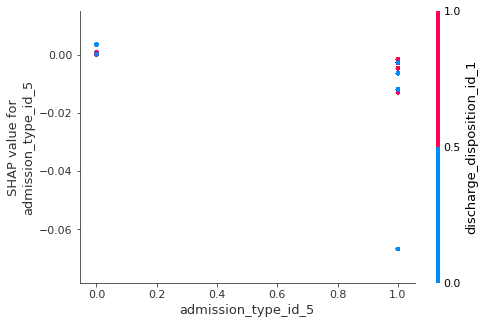

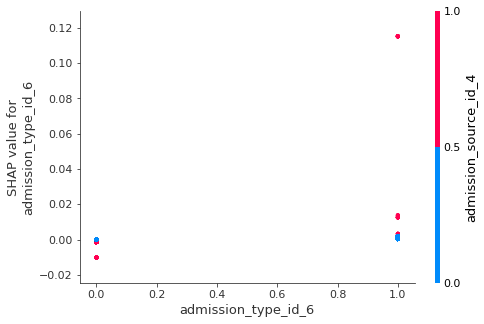

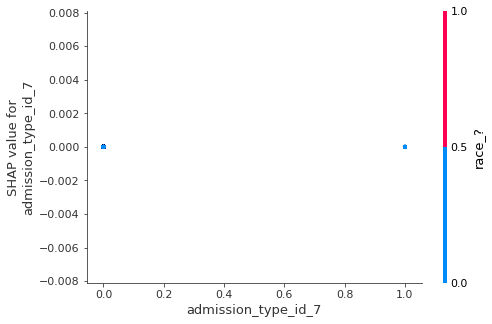

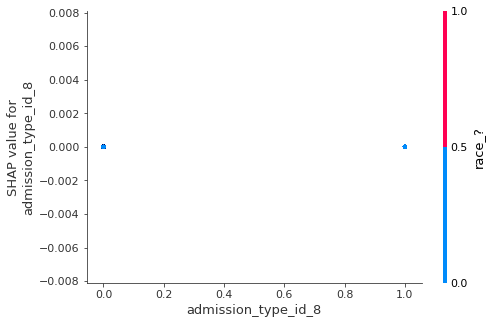

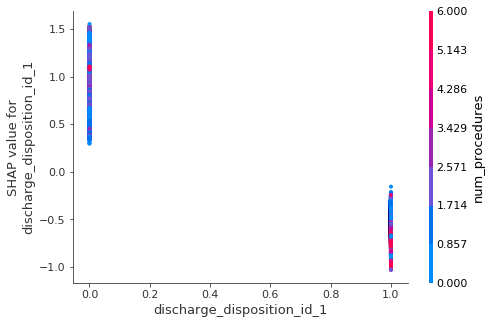

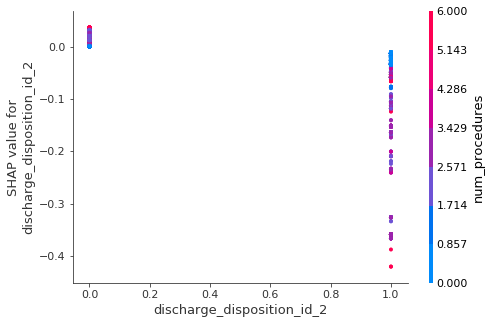

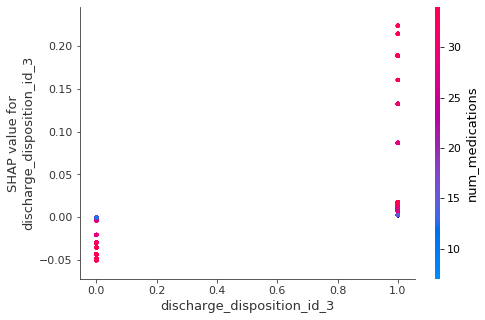

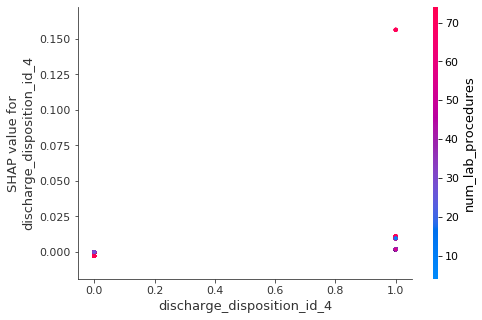

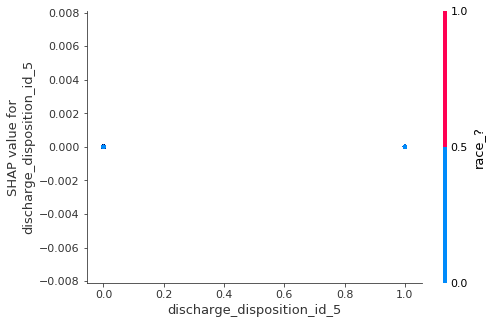

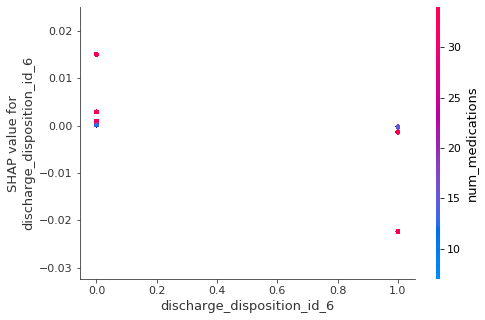

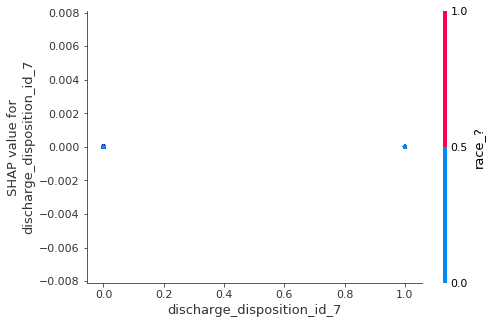

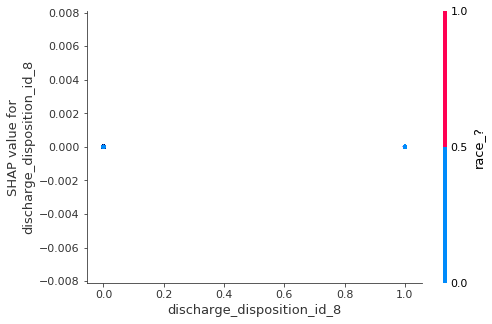

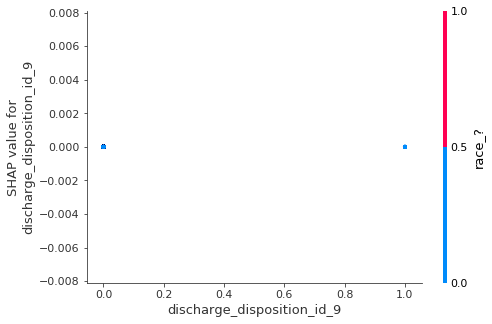

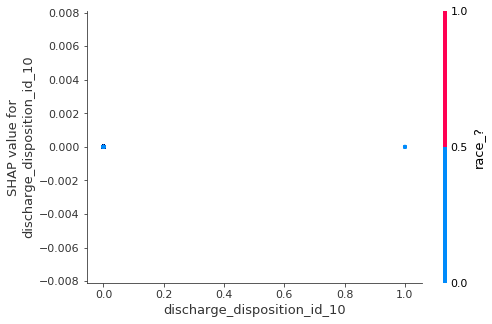

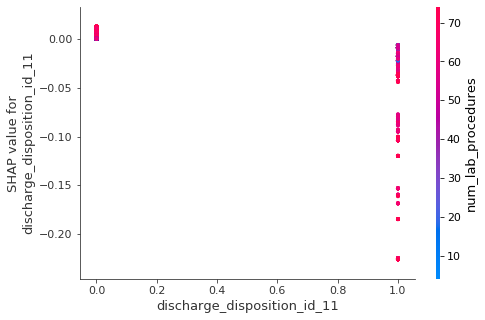

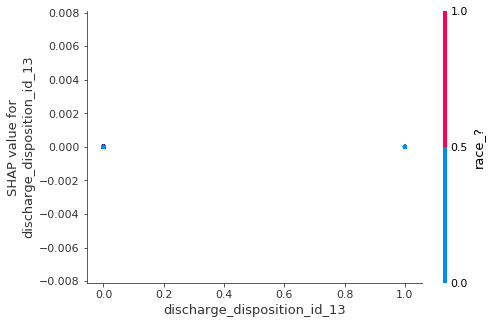

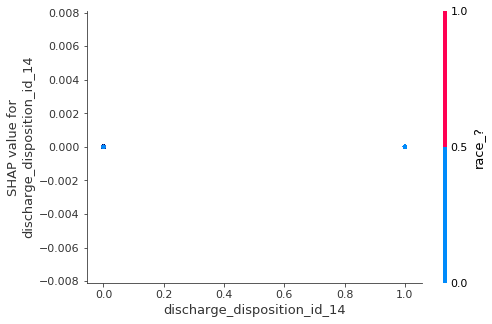

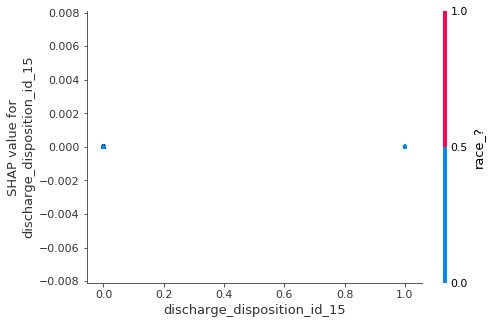

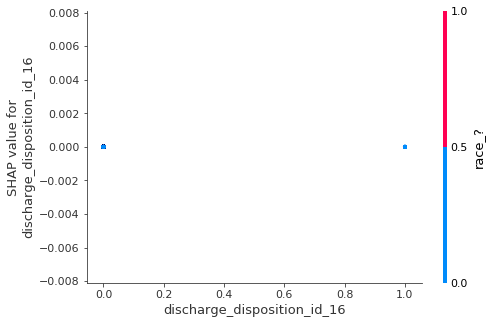

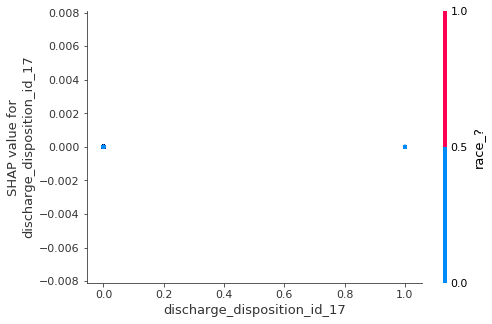

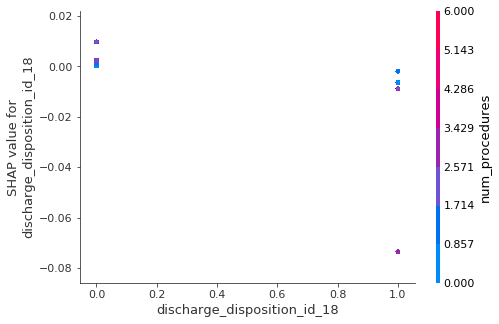

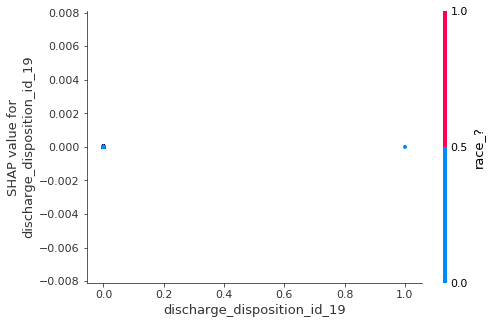

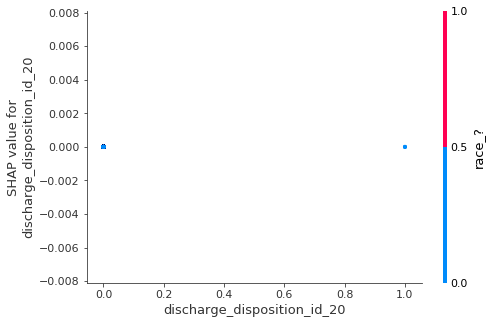

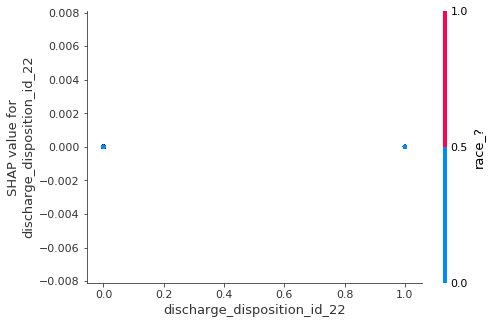

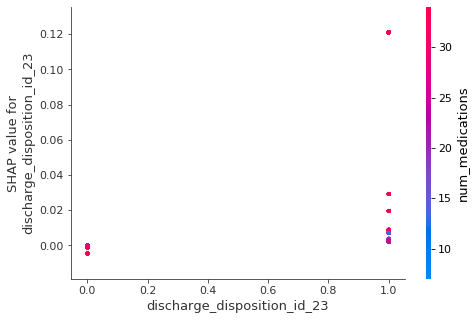

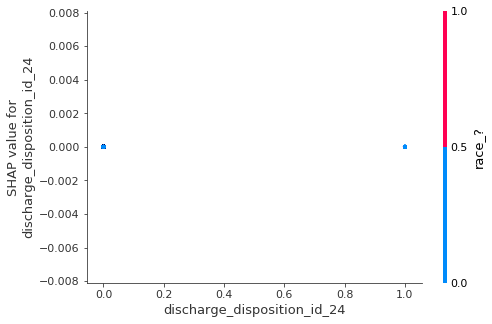

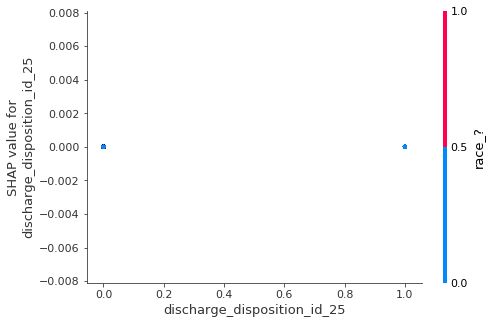

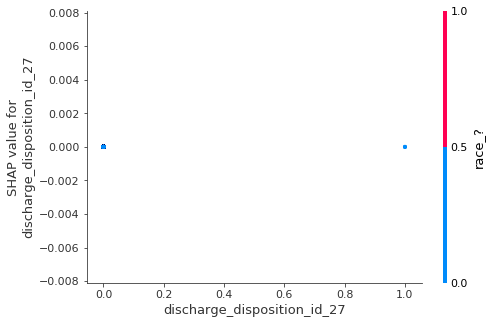

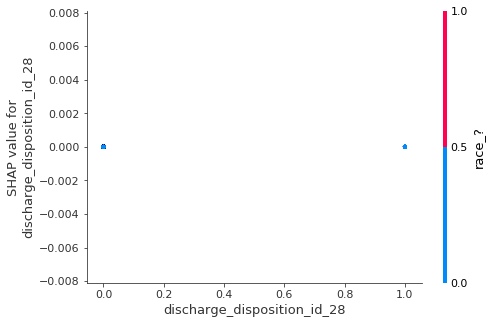

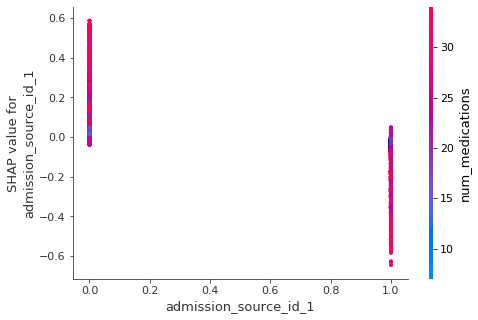

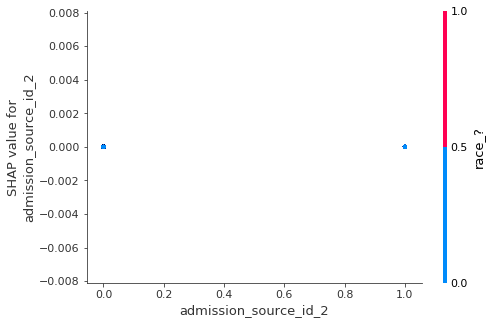

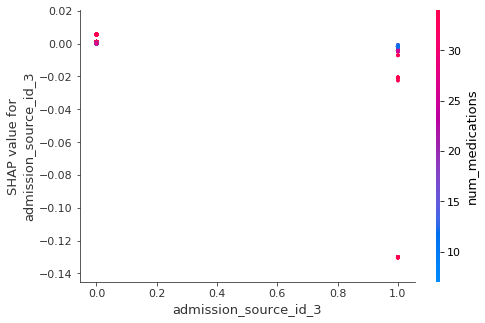

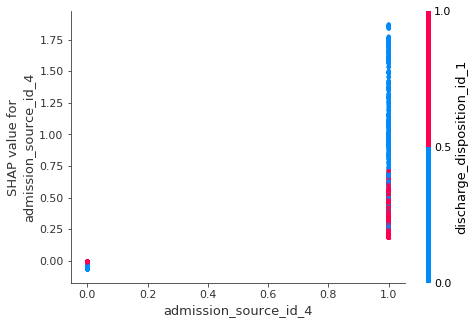

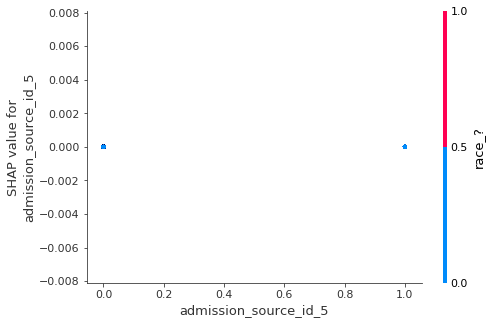

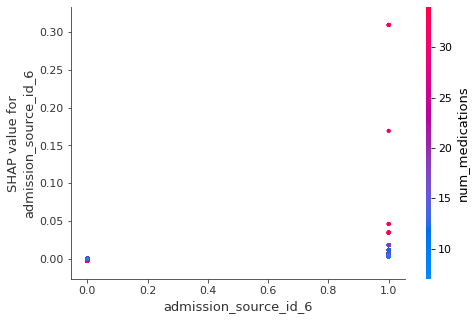

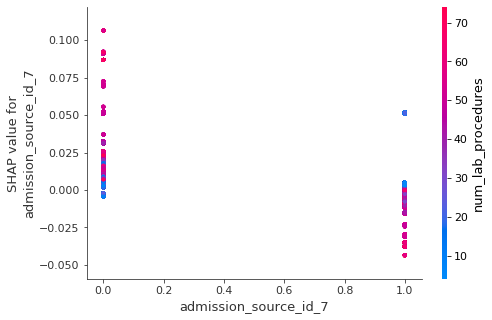

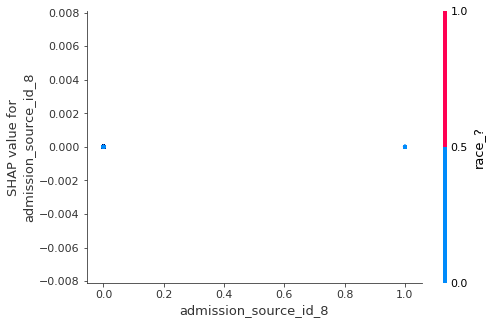

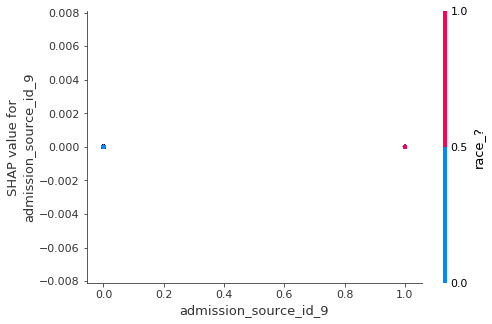

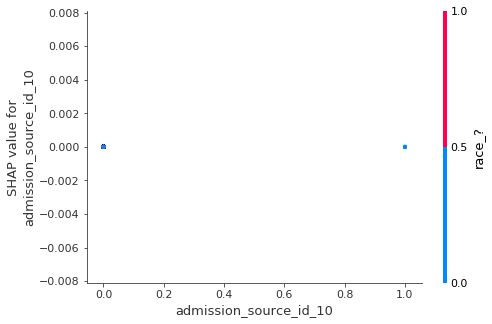

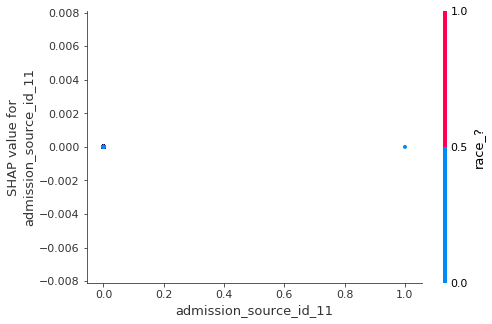

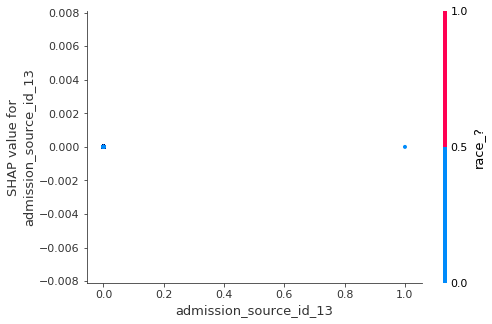

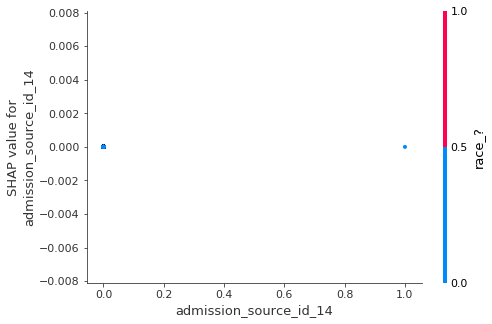

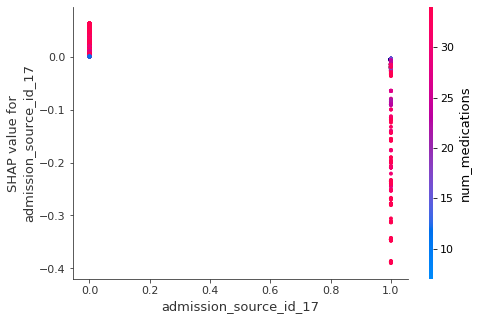

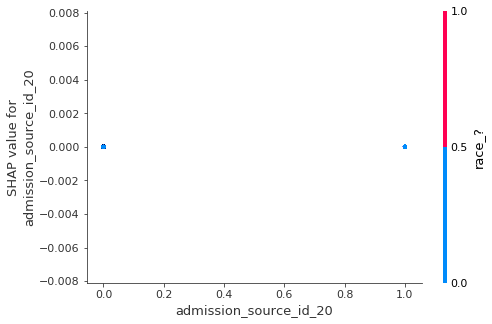

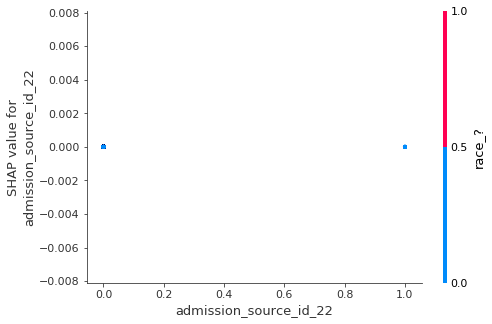

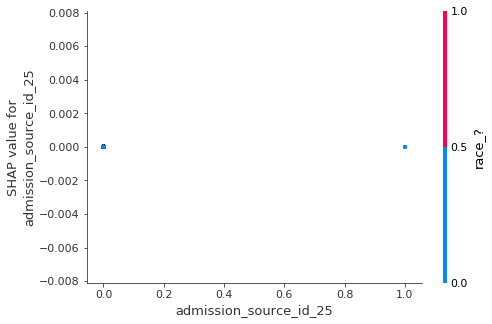

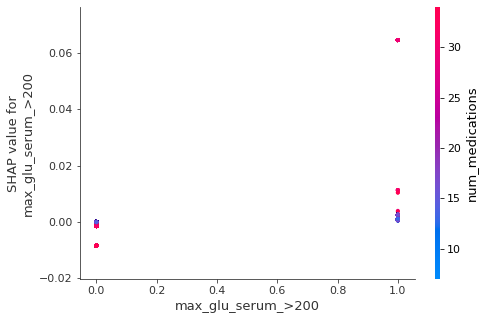

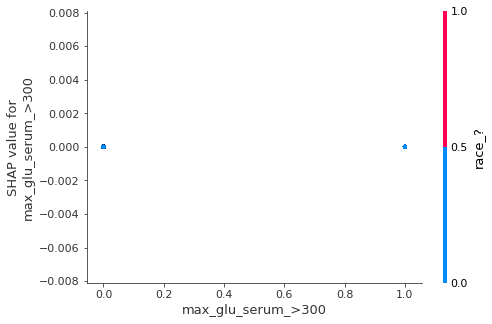

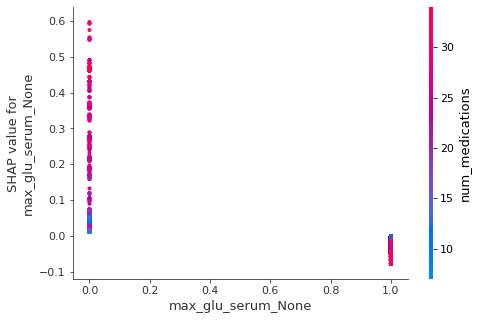

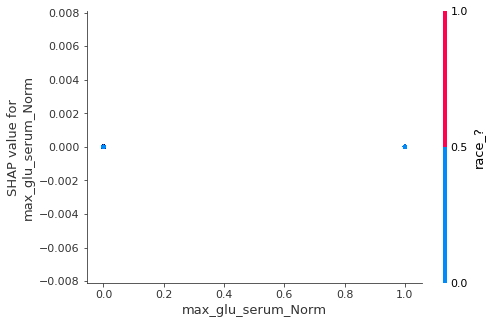

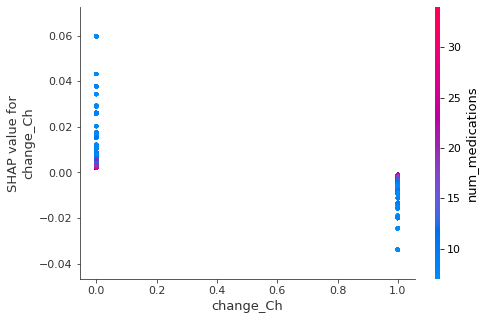

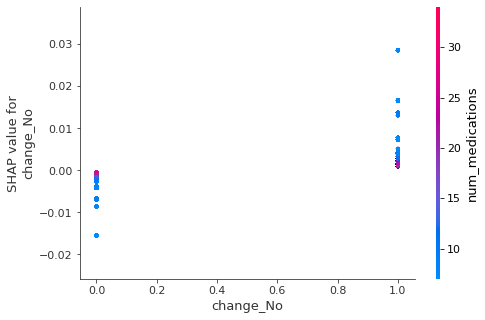

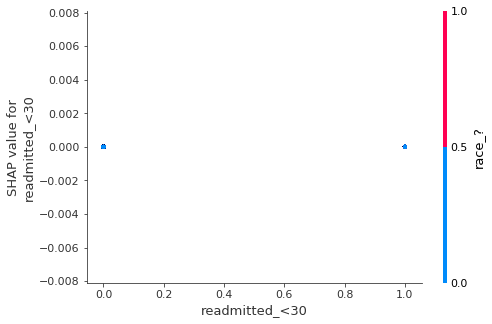

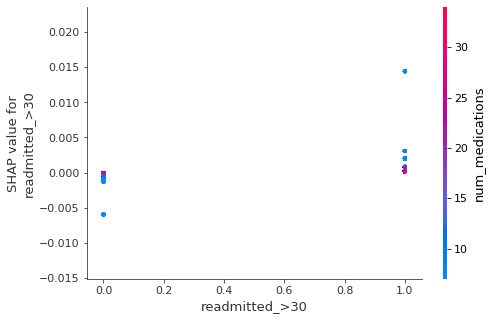

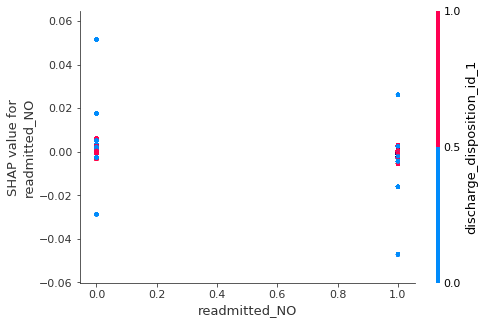

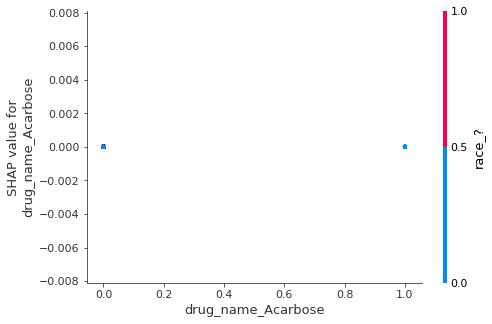

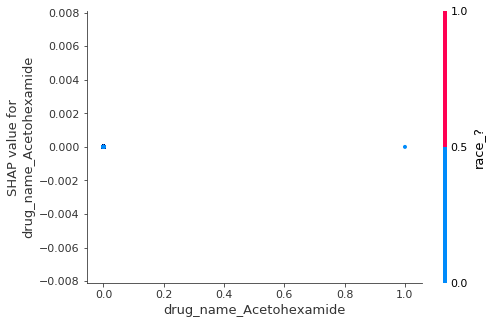

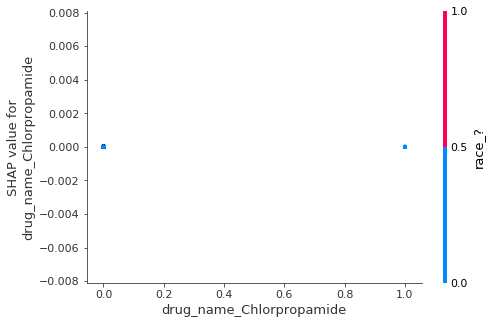

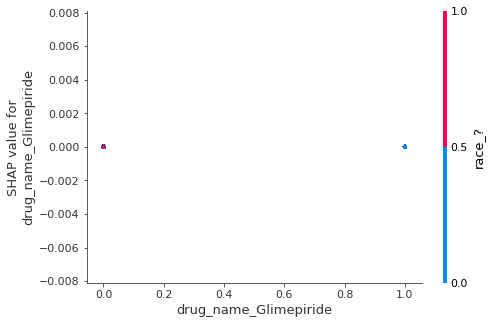

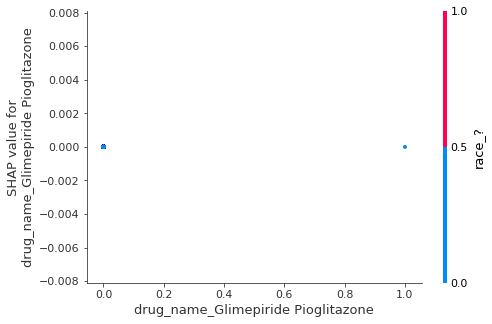

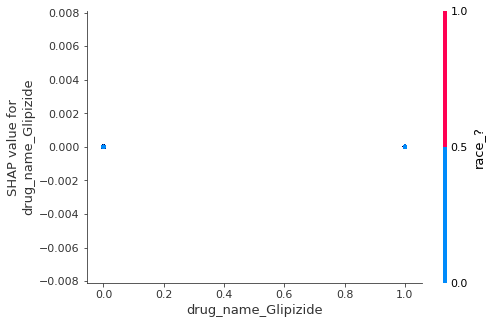

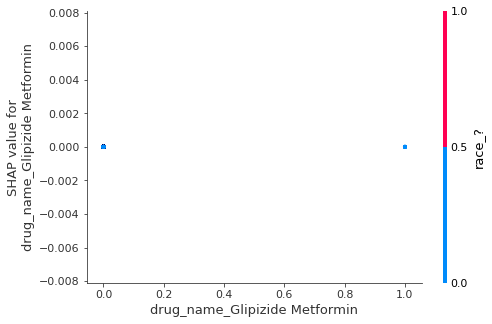

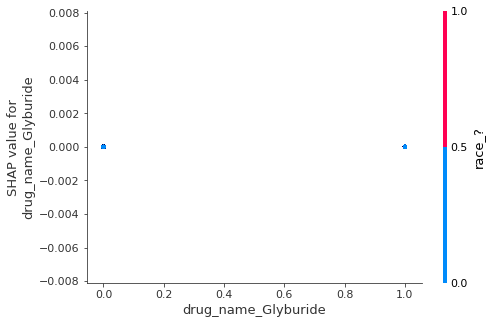

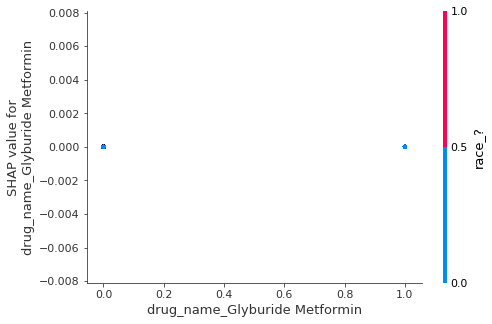

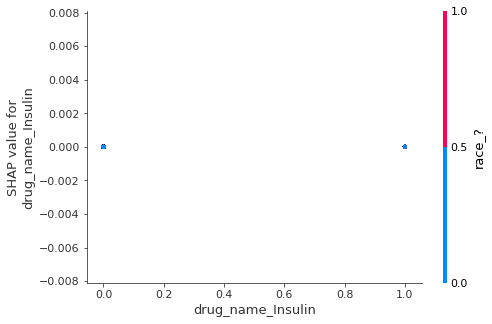

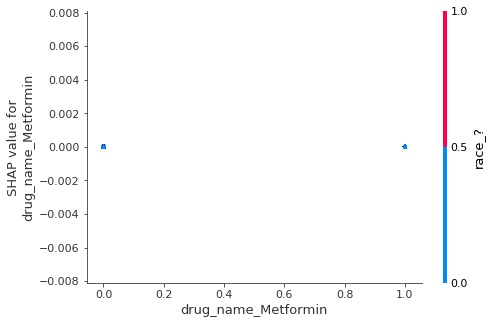

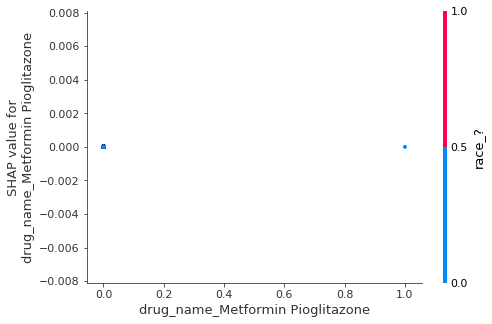

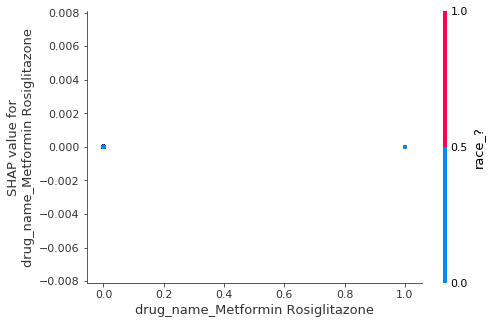

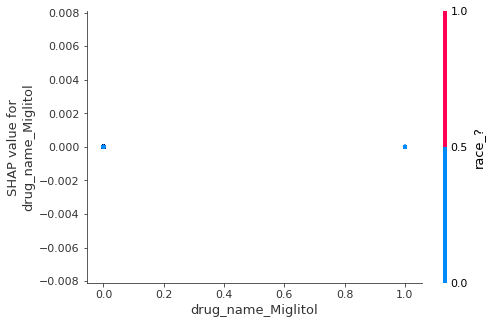

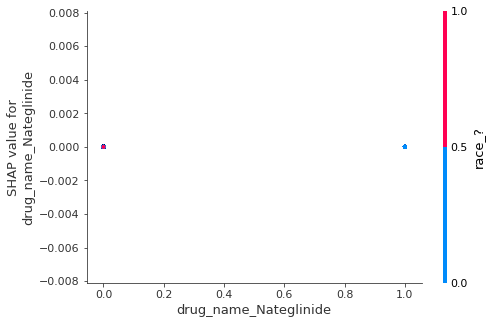

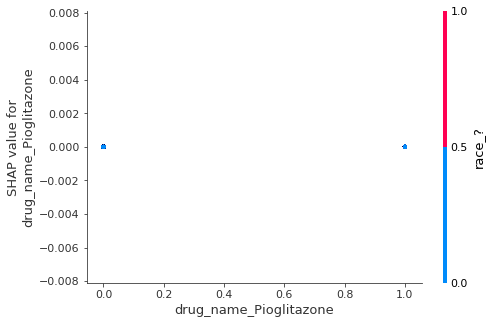

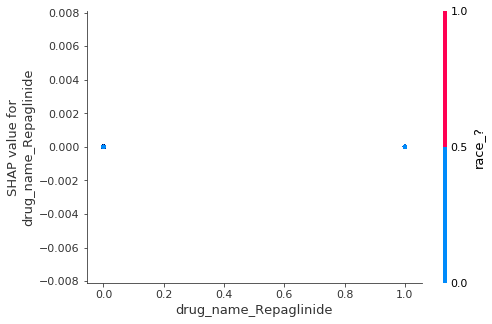

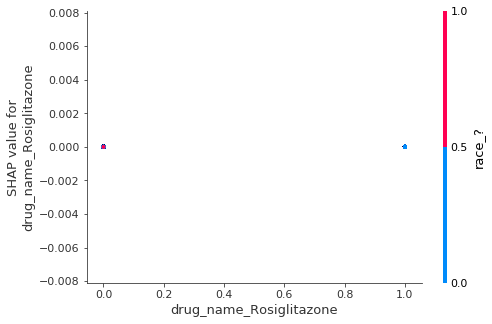

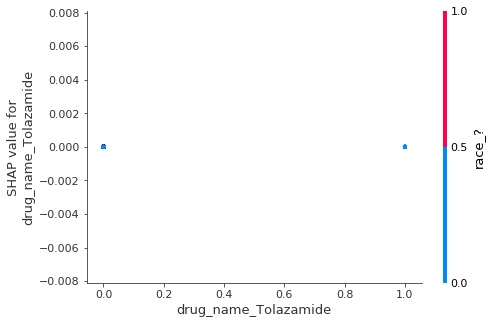

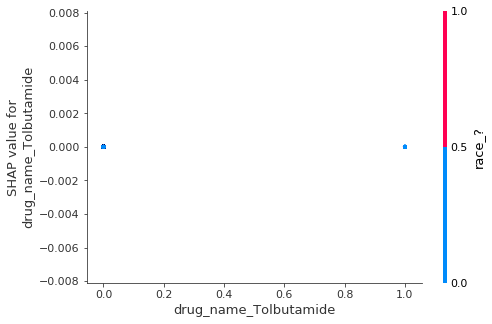

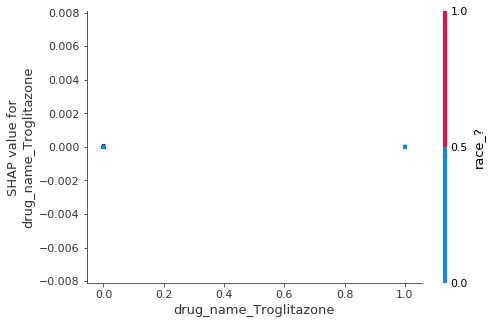

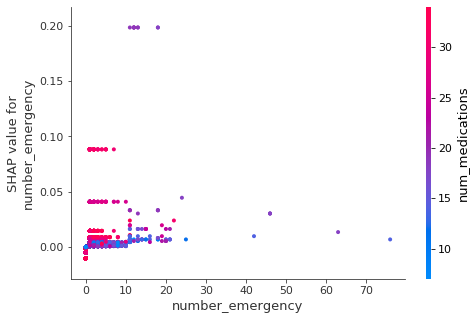

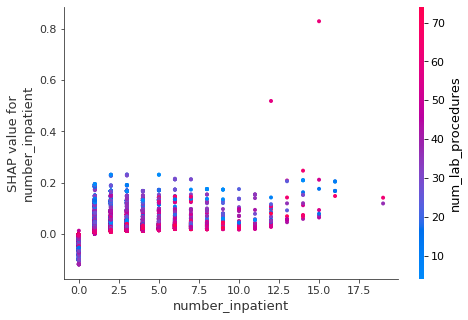

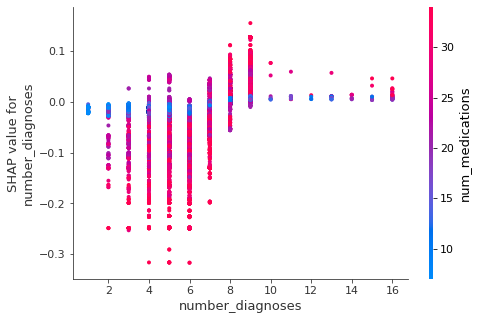

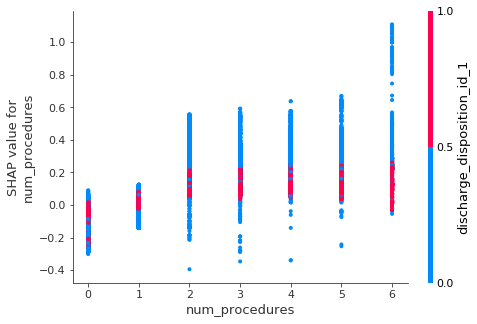

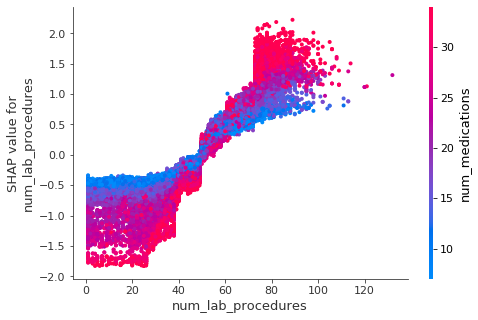

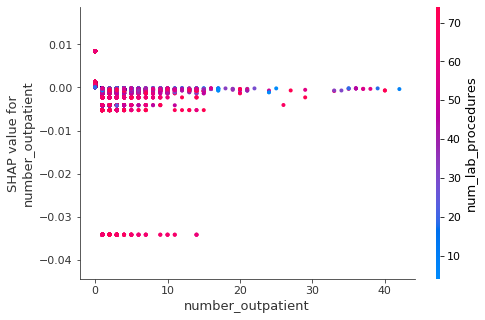

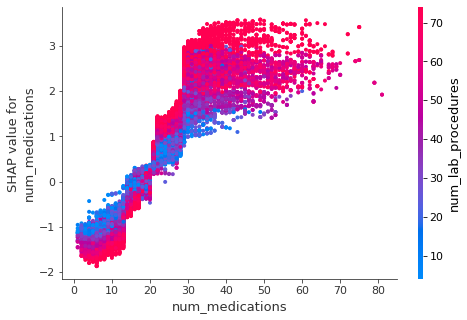

IndexError: index 106 is out of bounds for axis 1 with size 106

In [40]:
for i in range(len(train_combined)):
    shap.dependence_plot(i, shap_values, train_combined)

In [ ]:
shap.dependence_plot("num_medications", shap_values, train_combined)

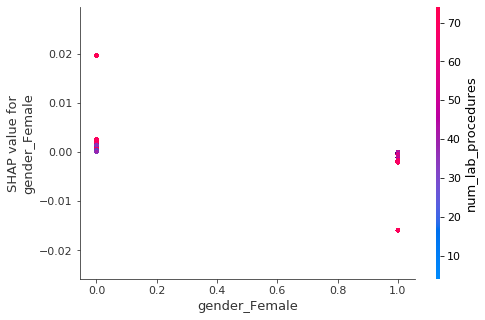

In [31]:
shap.dependence_plot("gender_Female", shap_values, train_combined)

### Force Plot

In [32]:
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(test_combined)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], test_combined.iloc[j])
    return(p)

In [33]:
shap_plot(0)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [34]:
shap_plot(10)

In [35]:
shap_plot(500)

In [36]:
shap_plot(1)

In [2]:
#explainerModel = shap.TreeExplainer(model)
#shap_values_Model = explainerModel.shap_values(test_combined)
#shap.force_plot(explainerModel.expected_value, shap_values_Model, test_combined)